# SGD with bias

In [1]:
import os

import numpy as np
import pandas as pd
from subprocess import call
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

## MovieLens Dataset

In [3]:
file_dir = '../data/ml-100k'
file_path = os.path.join(file_dir, 'u.data')

if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'])
    call(['unzip', 'ml-100k.zip'])
    
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, sep = '\t', names=names)
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# create the rating matrix r_{ui}
# remember to subtract the user and item id by 1 since the indices starts from 0
n_users = df['user_id'].unique().shape[0]
n_items = df['item_id'].unique().shape[0]
# initialize
ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index=False): # iterrowよりも高速
    ratings[row.user_id-1, row.item_id-1] = row.rating

# compute the no-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0] # retrun "indices" tha are non-zero
sparsity = (interaction/matrix_size) * 100

print('dimensition: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimensition:  (943, 1682)
sparsity: 6.3%


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [34]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(np.flatnonzero(ratings[user]), size=10, replace=False)
        
        train[user, test_index] = 0.0 # 学習データからは削除
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    # trainとtestの同じ位置の各要素の積をとり，全て０となるかをチェック
    # testはtrainのうち各ユーザ１０個ずつテストデータをとり，trainはその要素を0とする
    assert np.all(train * test == 0)
    return train, test

In [35]:
train, test = create_train_test(ratings)

In [36]:
train

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [37]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Matrix Factorization with SGD

With SGD, we again take derivatives of the loss function, but we take the derivative with respect to each variable in the model.  
The “stochastic” aspect of the algorithm involves taking the derivative and updating feature weights one individual sample at a time.  
So, for each sample, we take the derivative of each variable, set them all equal to zero, solve for the feature weights, and update each feature. Somehow this method actually converges.

We will use a similar loss function to before, but I am going to add some more details to the model.  
Instead of assuming that a user u’s rating for item i can be described simply by the dot product of the user and item latent vectors, we will consider that each user and item can have a bias term associated with them. 
The rational is that certan users might tend to rate all movies highly, or certain movies may tend to always have low ratings.  
The way that I think about it is that the bias term takes care of the “DC” part of the signal which allows the latent factors to account for the more detailed variance in signal (kind of like the AC part).  
We will also include a global bias term as well. With all things combined, our predicted rating becomes

$$\hat r_{ui} = \mu + \vec{b_u} + \vec{b_i} + \vec{x_u}^T \cdot \vec{y_i}$$

where $\mu$ is the global bias, and $\vec{b_u}(\vec{b_i})$ is the user (item) bias.  
Our loss function now becomes

$$L = \sum_{u,i}(\vec{r_{ui}} - (\mu + \vec{b_u} + \vec{b_i} + \vec{x_u}^T \cdot \vec{y_i}))^2 + \lambda_{xb}\sum_u|\vec{b_u}|^2 + \lambda_{yb}\sum_i|\vec{b_i}|^2 + \lambda_{xf}\sum_u|\vec{x_u}|^2 + \lambda_{yf}\sum_i|\vec{y_i}|^2$$

where we have added on extra bias regularization terms.  
We want to update each feature (user and item latent factors and bias terms) with each sample.  
The update for the user bias is given by

$$\vec{b_u}\gets\vec{b_u} - \eta\frac{\partial L}{\partial \vec{b_u}}$$

where $\eta$ is the learning rate which weights how much our update modifies the feature weights.  
The derivative term is given by

$$\frac{\partial L}{\partial \vec{b_u}} = 2(\vec{r_{ui}} - (\mu + \vec{b_u} +\vec{b_i} + \vec{x_u}^T \cdot \vec{y_i}))(-1) + 2\lambda_{xb}\vec{b_u}$$
$$\frac{\partial L}{\partial \vec{b_u}} = 2(\vec{e_{ui}})(-1) + 2\lambda_{xb}\vec{b_u}$$
$$\frac{\partial L}{\partial \vec{b_u}} = -\vec{e_{ui}} + \lambda_{xb}\vec{b_u}$$

where **$e_{ui}$ represents the error in our prediction** and we have dropped the factor of 2 (we can assume it gets rolled up in the learning rate). For all of our features, the updates end up being

$$\vec{b_u}\gets\vec{b_u} + \eta(\vec{e_{ui}} - \lambda_{xb}\vec{b_u})$$
$$\vec{b_i}\gets\vec{b_i} + \eta(\vec{e_{ui}} - \lambda_{yb}\vec{b_i})$$
$$\vec{x_u}\gets\vec{x_u} + \eta(\vec{e_{ui}}\vec{y_i} - \lambda_{xf}\vec{x_u})$$
$$\vec{y_i}\gets\vec{y_i} + \eta(\vec{e_{ui}}\vec{x_u} - \lambda_{yf}\vec{y_i})$$

In [121]:
class ExplicitMF():
    """
    Train a matrix factorization mode to predict empty entries in a matrix.
    Te terminology assumes a ratings matrix which is ~ user x item
    
    Parameters
    ----------------
    ratings : ndarray
        user x Item matrix with corresponding ratings
    
    n_factors : int
        number of latent factors to use in matrix
        factorization model, some machine-learning libraries denote this as 'rank'
        
    learnig : str
        method of optimization. 
        options include 'sgd' of 'als'.
        
    item_fact_reg : float
        regularization term for item latent factors
        
    user_fact_reg : float
        regularization term for user latent factors
        
    item_bias_reg : float
        regularization term for item biases
        
    user_bias_reg : float
        regularization term for user biases
        
    verbose : bool
        whether or not to printout training progress
    """
    
    def __init__(self, n_factors=40,
                     item_fact_reg=0.0, user_fact_reg=0.0, item_bias_reg=0.0, user_bias_reg=0.0, verbose=False):
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        
        self._v = verbose
        
        
    def fit(self, train, test, n_iters=10, learning_rate=0.1):
        # 初期化など
        self.ratings = train
        self.n_users, self.n_items = self.ratings.shape
        self.sample_row, self.sample_col = self.ratings.nonzero() # nonzeroのindexを返す
        self.n_samples = len(self.sample_row)
        
        # initrialize model for n_iter iterations from scratch
        # 平均0，標準偏差1のランダムな行列
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        self.learning_rate = learning_rate
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_items)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)]) # 評価値があるところのみで平均値をとりバイアス項を取る
        
        # sgd_step
        self.partial_train(n_iters)
        
        
    def partial_train(self, n_iters):
        """
        Train model for n_iter iterations.
        Can be called multiple times for further training.
        """
        self.test_mse_record = []
        self.train_mse_record = []
        ctr = 1
        while ctr <= n_iters:
#             if ctr % 10 == 0 and self._v:
            print('\tcurrent iteration: {}'.format(ctr))
            
            # SGD前に必要な処理
            # SGDアルゴリズムをかける前に，学習データをシャッフルする
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            # SGDアルゴリズム
            self.sgd()
            
            
#             # 作成したfactorsで予測行列を算出
#             predictions = self.predict_all()
            
#             # optional
#             # MSEを記録
#             test_mse = self.compute_mse(test, predictions)
#             train_mse = self.compute_mse(train, predictions)
#             self.test_mse_record.append(test_mse)
#             self.train_mse_record.append(train_mse)
#             print('iter: {}, test_mse: {}, train_mse: {}'.format(it+1, test_mse, train_mse))
            
            ctr += 1
        
        
    def sgd(self):
        for idx in self.training_indices:
            # 値が存在するindexを取得
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            
            prediction = self.predict(u, i) # 現在の予測値を得る
            
            e = (self.ratings[u, i] - prediction) # 損失を取得
            
            
            # Update bias
            self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])
            
            # Update latent factors
            self.user_vecs[u, :] += self.learning_rate * (e *  self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u, :])
            self.item_vecs[i :] += self.learning_rate * (e *  self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i, :])
            
            
    def predict(self, u, i):
        """
        SIngle user and item prediction.
        """
        prediction = self.global_bias + self.user_bias[u] + self.item_bias[i] + self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            
        return prediction

    def predict_all(self):
        """
        ALL user and item prediction.
        """
        predictions = np.zeros((self.user_vecs.shape[0], self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """
        ignore zero terms prior to comparing the mse
        """
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [119]:
def plot_learning_curve(model):
    """
    visualize the training/testing loss
    """
    linewidth = 3
    plt.plot(model.test_mse_record, label='Test', linewidth=linewidth)
    plt.plot(model.train_mse_record, label='Train', linewidth=linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc='best')

	current iteration: 1


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in add
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: overflow encountered in multiply
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value enco

	current iteration: 2
	current iteration: 3
	current iteration: 4
	current iteration: 5
	current iteration: 6
	current iteration: 7
	current iteration: 8
	current iteration: 9
	current iteration: 10


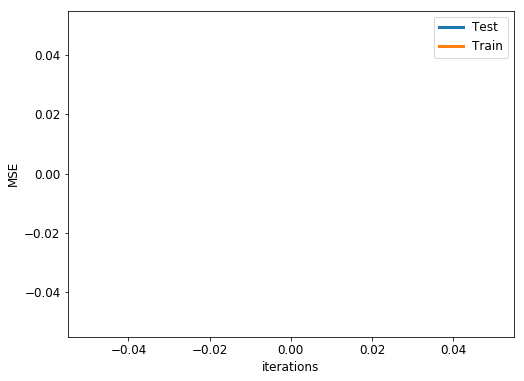

In [123]:
als = ExplicitMF(n_factors=40)
als.fit(train, test, n_iters=10, learning_rate=0.1)
plot_learning_curve(als)

In [7]:
ratings.nonzero()

(array([  0,   0,   0, ..., 942, 942, 942]),
 array([   0,    1,    2, ..., 1187, 1227, 1329]))

In [9]:
np.random.normal(size=(4,2))

array([[ 0.67976143,  1.17568078],
       [ 1.47171869, -0.66332343],
       [ 0.31716043, -0.83590805],
       [ 1.45191654, -2.14176248]])